Make sure spark object is created.

In [3]:
spark

Import system packages.

In [4]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.sql import Column as col

if 'notebooks' in os.getcwd():
    os.chdir('..')

In [5]:
# For playing a beep at the end of very long computations
from IPython.display import Audio
sound_file = 'http://www.soundjay.com/button/beep-07.wav'
# Paste the following code at the bottom of a long-running cell:
# Audio(sound_file, autoplay=True)

Define useful funcions.

In [6]:
def get_df(resonance,era,subEra):

    useParquet = True
    
    if useParquet:
        fnames = list(registry.parquet(
            particle, probe, resonance, era, subEra))
        print(fnames)
    else:
        fnames = registry.root(particle, probe, resonance, era, subEra)
        fnames = ['root://eoscms.cern.ch/'+f for f in fnames]

    doGen = subEra in ['DY_madgraph', 'JPsi_pythia8']

    # default numerator/denominator defintions
    definitions = my_config.definitions()

    # for when we use root files instead of parquet
    # treename = 'tpTree/fitter_tree'
    treename = 'muon/Events'
    
    # get the dataframe
    if useParquet:
        print('Loading parquet files:', fnames)
        if isinstance(fnames, list):
            baseDF = spark.read.parquet(*fnames)
        else:
            baseDF = spark.read.parquet(fnames)
    else:
        treename = registry.treename(particle, probe, resonance, era, subEra)
        baseDF = spark.read.format("root")\
                      .option('tree', treename)\
                      .load(fnames)
        
    defDF = baseDF
    for d in definitions:
        defDF = defDF.withColumn(d, F.expr(definitions[d]))

    # select tags
    tagsDF = defDF.filter(my_config.selection())        
        
    # build the weights (pileup for MC)
    weightedDF = get_weighted_dataframe(tagsDF, doGen, resonance, era, subEra)
    
    # create the binning structure
    fitVariable = my_config.fitVariable()
    binningSet = set([fitVariable])
    if doGen:
        fitVariableGen = my_config.fitVariableGen()
        binningSet = binningSet.union(set([fitVariableGen]))
    binVariables = my_config.binVariables()
    for bvs in binVariables:
        binningSet = binningSet.union(set(bvs))

    binning = my_config.binning()
    variables = my_config.variables()
    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(
            binnedDF, bName+"Bin",
            variables[bName]['variable'],
            binning[bName])

    return binnedDF

    
def plot(dfs, plotVar, edges, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = None
    if 'Run2018A' in dfs.keys():
        data = 'Run2018A'

    def reduce_df(df):
        df = get_binned_dataframe(df, 'tmpBin', plotVar, edges)
        df = df.groupBy('tmpBin').agg({'weight': 'sum', 'weight2': 'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index('tmpBin').sort_index()
        return df
    
    if data is not None:
        df = reduce_df(dfs['Run2018A'])
    if sim is not None:
        df_mc = reduce_df(dfs[sim])
    
    bx = edges
    if data is not None:
        y = pd.Series(np.zeros(len(edges)+1))
        yerr = pd.Series(np.zeros(len(edges)+1))
    if sim is not None:
        y_mc = pd.Series(np.zeros(len(edges)+1))
        yerr_mc = pd.Series(np.zeros(len(edges)+1))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if data is not None:
        y[df.index] = df['sumw']
        integral = sum(y)
        y = y/integral
        y = y[1:len(bx)]
        yerr[df.index] = np.sqrt(df['sumw2']) 
        yerr = yerr / integral
        yerr = yerr[1:len(bx)]
    
    if sim is not None:
        y_mc[df_mc.index] = df_mc['sumw']
        integral_mc = sum(y_mc)
        y_mc = y_mc / integral_mc
        y_mc = y_mc[1:len(bx)]
        yerr_mc[df_mc.index] = np.sqrt(df_mc['sumw2']) 
        yerr_mc = yerr_mc / integral_mc
        yerr_mc = yerr_mc[1:len(bx)]
    
    if data is not None:
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
        # plt.yscale('log')
    if sim is not None:
        plt.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
    
    leg = []
    if data is not None:
        leg += ['Data']
    if sim is not None:
        leg += ['Simulation']
    plt.legend(leg,frameon=False)
        
    plt.ylabel('Unit normalized')
    plt.xlabel(xlabel)
    if additional_text: plt.text(bx[0],0.95*max([max(y),max(y_mc if sim is not None else 0.0)]), additional_text)
    plt.show()

Import local package modules and config.

In [7]:
from flattener import *
from registry import registry
from config import Configuration
my_config = Configuration('configs/dSAMuons_Z.json')
# my_config = Configuration('configs/dSAMuons_Z_truth.json')
# my_config = Configuration('configs/dSAMuons_JPsi.json')

Load dataframe from parquet files.

In [8]:
particle = 'muon'
probe = 'dSAMuons'
resonance = 'Z'
# resonance = 'JPsi'
era = 'Run2018'
subEras = ['Run2018A', 'DY_madgraph']
# subEras = ['Run2018A', 'JPsi_pythia8']

dfs = {subEra: get_df(resonance,era,subEra) for subEra in subEras}
dfs_pt20 = {subEra: dfs[subEra].filter('probe_dsa_pt>20') for subEra in subEras} # for use with no pT binned plots
dfs_dsa = {subera: dfs[subera].filter('probe_isdSA==1') for subera in subEras}
dfs_gen = {subera: dfs_dsa[subera].filter('tag_isMatchedGen==1 and probe_isMatchedGen==1') for subera in subEras}

['/user/asterenb/parquet/muon/Z/Run2018/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2018/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/Run2018/DY_madgraph/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2018/DY_madgraph/tnp.parquet']


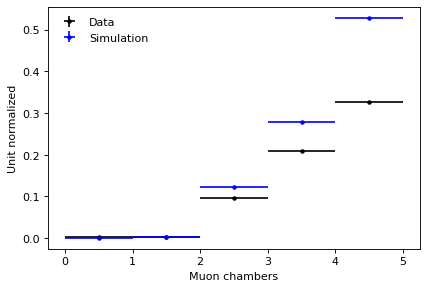

In [164]:
plot(dfs, 'probe_muonStations', np.array(np.arange(0, 6, 1)), 
     xlabel=r'Muon chambers', high_quality=False)

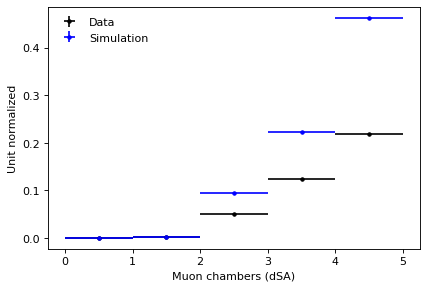

In [9]:
plot(dfs, 'probe_dsa_muonStations', np.array(np.arange(0, 6, 1)), 
     xlabel=r'Muon chambers (dSA)', high_quality=False)

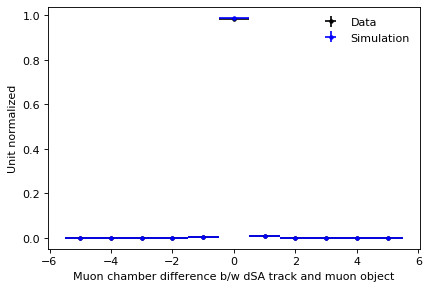

In [178]:
new_dfs = {subEra: dfs[subEra].filter('probe_isdSA==1') for subEra in subEras}
new_dfs = {subEra: new_dfs[subEra].withColumn('muonStationDiff', new_dfs[subEra]['probe_dsa_muonStations'] - new_dfs[subEra]['probe_muonStations']) for 
          subEra in subEras}
plot(new_dfs, 'muonStationDiff', np.array(np.arange(-5.5, 6.5, 1)), 
     xlabel=r'Muon chamber difference b/w dSA track and muon object', high_quality=False)

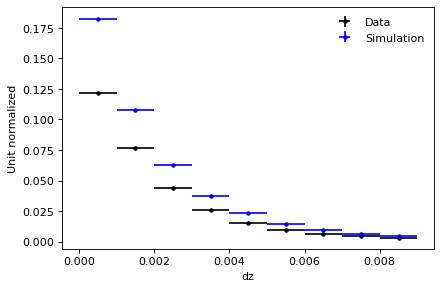

In [93]:
plot(dfs, 'probe_dz', np.array(np.arange(0, 0.01, .001)), 
     xlabel=r'dz', high_quality=False)

Compute pass and fail results for efficiency given numerator and denominator.

In [10]:
def get_params(df,num,den,binVars,cutAndCount=True):

    reducedDF = df.filter(df[den]==True)

    reducedDF = reducedDF.withColumn('den',F.lit(den))
    reducedDF = reducedDF.withColumn('num',F.lit(num))
    reducedDF = reducedDF.withColumnRenamed(num,'pass')

    reducedDF = reducedDF.groupBy('pass','num','den',*[b+'Bin' for b in list(binVars)+['mass']]).agg({'weight': 'sum', 'weight2': 'sum'})
    reducedDF = reducedDF.withColumnRenamed('sum(weight)','sumw')
    reducedDF = reducedDF.withColumnRenamed('sum(weight2)','sumw2')

    # for wrapping a fit
    #fit_wrapper = FitWrapper(crystalball_exponential)
    #fit_udf = fit_wrapper()
    #fitparams = summedDF.groupby(['pass','num','den','absetaBin','ptBin']).apply(fit_udf)
    #realized = fitparams.toPandas()

    if cutAndCount:
        # for simple cut and count
        narrowWindow = reducedDF#.filter('massBin >= 31 and massBin <= 41')
        countsDF = narrowWindow.groupby(['pass','num','den']+[b+'Bin' for b in list(binVars)]).agg({'sumw': 'sum', 'sumw2': 'sum'})
        countsDF = countsDF.withColumnRenamed('sum(sumw)','sumw')
        countsDF = countsDF.withColumnRenamed('sum(sumw2)','sumw2')
        realized = countsDF.toPandas()
    else:
        realized = reducedDF.toPandas()

    return realized

In [11]:
# num, den = 'TightID', 'TrackerMuons'
num, den = 'dSAMuons', 'genTracks'
realized_abseta_pt = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}
# realized_abseta_nvtx = {subEra: get_params(dfs[subEra], num, den, ['nvtx']) for subEra in subEras}

In [12]:
def get_eff(df,binVars):
    '''return a df with keys eff, eff_err, num, den, ... '''
    df_num = df[df['pass']==True].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_den = df[df['pass']==False].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_num['eff'] = df_num['sumw'] / (df_den['sumw'] + df_num['sumw'])
    # TODO binomial with w!=1
    p = df_num['sumw']
    f = df_den['sumw']
    N = p+f
    df_num['eff_err'] = 1/N * np.sqrt(p*(1-p/N))
    return df_num[['eff','eff_err']]


def plot_eff(dfs, num, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = my_config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = None
    if 'Run2018A' in dfs.keys():
        data = 'Run2018A'
    
#     df = dfs['Run2017C']
    if data is not None:
        df = dfs[data]
    if sim is not None:
        df_mc = dfs[sim]
        
    print('len bx ', len(bx))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    print(x)
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    print(xerr)
    
    if data is not None:
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
        print('xerr shape ', len(xerr), ' yerr shape ', len(yerr))

    if sim is not None:
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
    
    if sim is not None and data is not None:
        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
    else:
        fig, ax0 = plt.subplots(1)

    if data is not None:
        ax0.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k', label='Data')
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b', label='Simulation')
    ax0.legend(frameon=False)
    ax0.set_ylabel('Efficiency')
    ax0.set_ylim(0.0,1.2)
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.90, f'{num} / {den}', transform=ax0.transAxes)
    ax0.text(0.05, 0.82, additional_text, transform=ax0.transAxes)
    ax0.label_outer()
    
    if sim is not None and data is not None:
        ratio = y/y_mc
        err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,yerr=err_ratio,fmt='.r')
        ax1.set_ylabel('Data/Simulation')
        ax1.set_ylim(0.8,1.1)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    fig.show()
    
def plot_truth_eff(dfs, num, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = my_config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
    
    df_truth = dfs['truth']
    if sim is not None:
        df_mc = dfs[sim]

    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    y = df_truth['eff'][1:len(bx)-1]
    yerr = df_truth['eff_err'][1:len(bx)-1]
        
    if sim is not None:
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
    
    if sim is not None:
        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
    else:
        fig, ax0 = plt.subplots(1)
    
    leg = []
    ax0.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    leg += ['Truth']
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        leg += ['Simulation']
        
    ax0.legend(leg, frameon=False)
        
    ax0.set_ylabel('Efficiency')
    ax0.set_ylim(0.6,1.2)
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.9, f'{num} / {den}', transform=ax0.transAxes)
    ax0.text(0.05, 0.8, additional_text, transform=ax0.transAxes)
    
    if sim is not None:
        ratio = y/y_mc
        err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,yerr=err_ratio,fmt='.r')
        ax1.set_ylabel('Truth/Simulation')
        ax1.set_ylim(0.95,1.05)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    ax0.label_outer()
    
    fig.show()

len bx  13
xerr shape  11  yerr shape  11


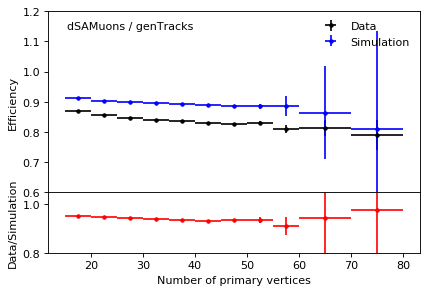

In [48]:
df_eff = {subEra: get_eff(realized_abseta_nvtx[subEra], ['nvtx']) for subEra in subEras}
bz = my_config.binning()['nvtx']
plot_eff(df_eff, num, den, 'nvtx', xlabel=r'Number of primary vertices', high_quality=False)

len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7


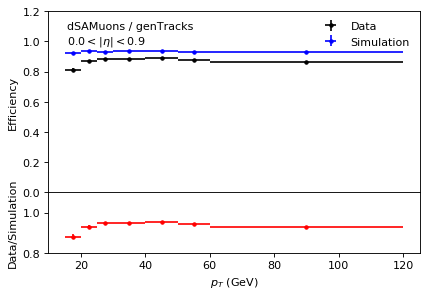

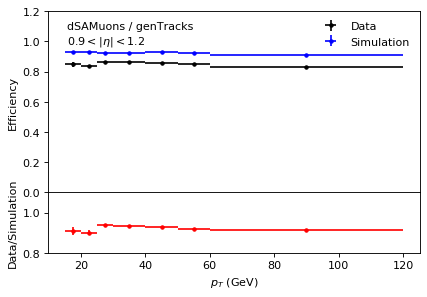

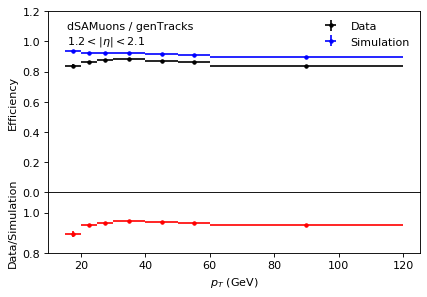

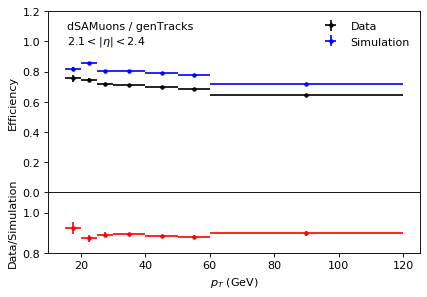

In [13]:
# df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')).unstack(fill_value=0).stack() for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

Filter by requiring exactly 2 muon stations in the probe (generalTrack).

In [12]:
# num, den = 'TightID', 'TrackerMuons'
num, den = 'dSAMuons', 'genTracks'
realized_abseta_pt = {subEra: get_params(dfs[subEra].filter('probe_muonStations==2'), num, den,('abseta','pt')) for subEra in subEras}
# realized_abseta_nvtx = {subEra: get_params(dfs[subEra], num, den, ['nvtx']) for subEra in subEras}
Audio(sound_file, autoplay=True)

Look at some details of the dataset.

In [158]:
realized_abseta_pt['Run2018A'][realized_abseta_pt['Run2018A']['pass']==False].set_index(['num','den']+[b+'Bin' for b in ['abseta', 'pt']]).sort_index()#.loc[idx['StandAloneMuons','genTracks']]

pass    sumw   sumw2
num             den       absetaBin ptBin                       
StandAloneMuons genTracks 1.0       1.0    False    82.0    82.0
                                    2.0    False   130.0   130.0
                                    3.0    False   262.0   262.0
                                    4.0    False  1343.0  1343.0
                                    5.0    False  1953.0  1953.0
                                    6.0    False   514.0   514.0
                                    7.0    False   543.0   543.0
                                    8.0    False   124.0   124.0
                          2.0       1.0    False    17.0    17.0
                                    2.0    False    39.0    39.0
                                    3.0    False    57.0    57.0
                                    4.0    False   288.0   288.0
                                    5.0    False   448.0   448.0
                                    6.0    False   129.0   129.0
                                    7.0    False   125.0   125.0
                                    8.0    False    30.0    30.0
                          3.0       1.0    False    29.0    29.0
                                    2.0    False    36.0    36.0
                                    3.0    False    71.0    71.0
                                    4.0    False   220.0   220.0
                                    5.0    False   381.0   381.0
                                    6.0    False   117.0   117.0
                                    7.0    False   151.0   151.0
                                    8.0    False    68.0    68.0
                          4.0       1.0    False    17.0    17.0
                                    2.0    False    17.0    17.0
                                    3.0    False    35.0    35.0
                                    4.0    False   156.0   156.0
                                    5.0    False   231.0   231.0
                                    6.0    False    73.0    73.0
                                    7.0    False    95.0    95.0
                                    8.0    False    39.0    39.0

Plot with this filter.

len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7


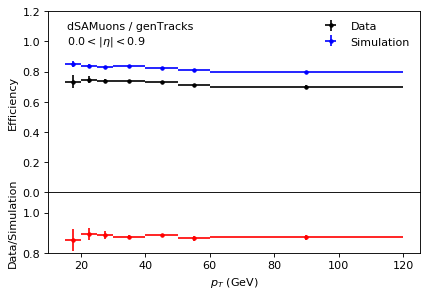

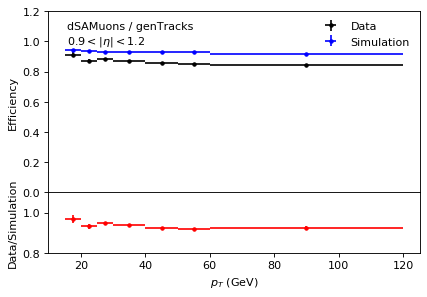

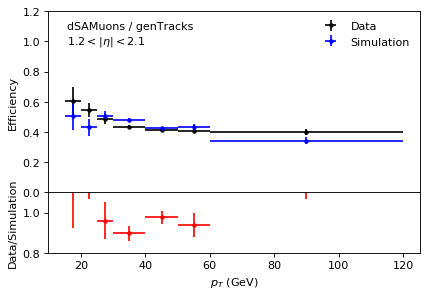

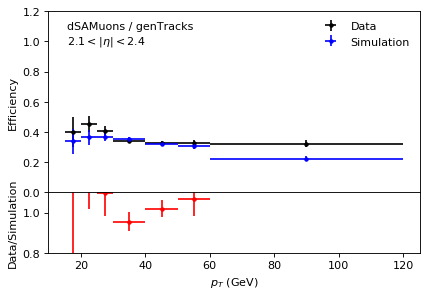

In [13]:
# df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')).unstack(fill_value=0).stack() for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

The efficiency is considerably lower here than the 'overall' efficiency. Now let's compare with requiring 4 muon chambers in the probe instead.

In [15]:
# num, den = 'TightID', 'TrackerMuons'
num, den = 'dSAMuons', 'genTracks'
realized_abseta_pt = {subEra: get_params(dfs[subEra].filter('probe_muonStations==4'), num, den,('abseta','pt')) for subEra in subEras}
# realized_abseta_nvtx = {subEra: get_params(dfs[subEra], num, den, ['nvtx']) for subEra in subEras}
Audio(sound_file, autoplay=True)

len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7
len bx  8
[17.5, 22.5, 27.5, 35.0, 45.0, 55.0, 90.0]
[2.5, 2.5, 2.5, 5.0, 5.0, 5.0, 30.0]
xerr shape  7  yerr shape  7


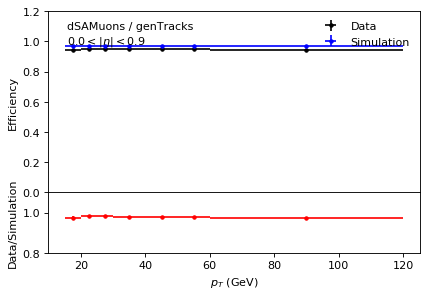

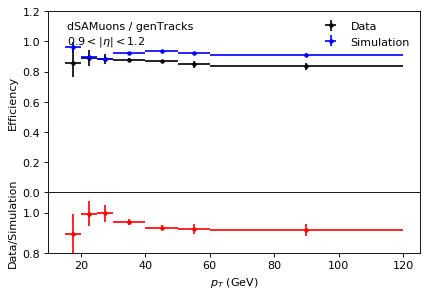

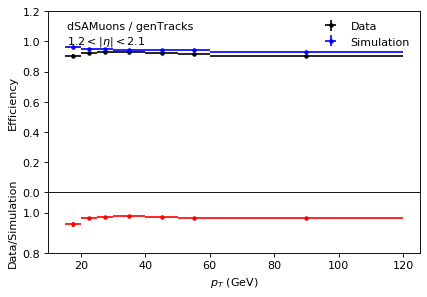

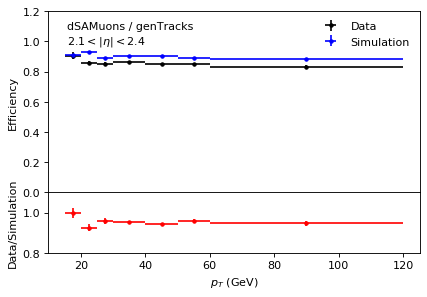

In [16]:
# df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')).unstack(fill_value=0).stack() for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

Now dSA efficiency is much closer to 1 in all eta ranges! Seems to suggest that the efficiency is a function of the number of muon stations in the reconstructed probe.

Now let's use StandAloneMuons as a reference to compare.

In [74]:
# num, den = 'TightID', 'TrackerMuons'
num, den = 'StandAloneMuons', 'genTracks'
realized_abseta_pt = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}
# realized_abseta_nvtx = {subEra: get_params(dfs[subEra], num, den, ['nvtx']) for subEra in subEras}

len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6


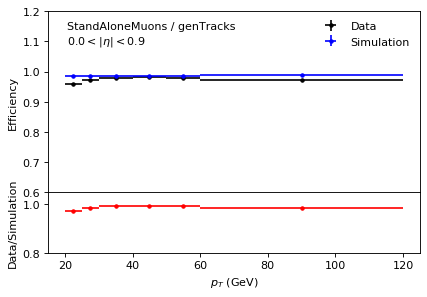

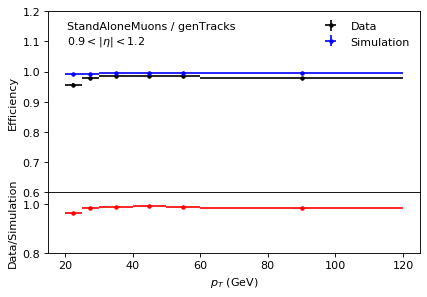

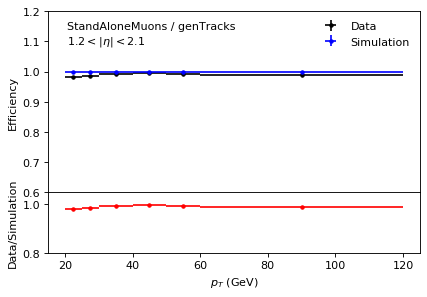

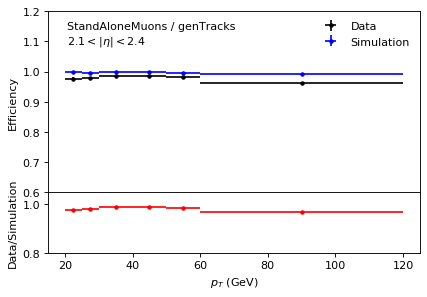

In [75]:
# df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

SA efficiency is close to 1, a likely suggestion that the method is sound and the lower dSA efficiency we are seeing is real. But would like to understand why exactly dSA eff is so much lower with 2 muon chambers than 4.

We can also plot the muons that are reconstructed by SA but not by dSA.

In [ ]:
def plot_passSA_faildSA(dfs, num='SAnotdSA', den='genTracks', plotVar='pt', xlabel='', absetaBin=None, additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = my_config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = None
    if 'Run2018A' in dfs.keys():
        data = 'Run2018A'

    if data is not None:
        df = dfs[data]
        df = df[df['pass']==True].set_index(['num','den']+[b+'Bin' for b in ['abseta', plotVar]]).sort_index()
    if sim is not None:
        df_mc = dfs[sim]
        df_mc = df_mc[df_mc['pass']==True].set_index(['num','den']+[b+'Bin' for b in ['abseta', plotVar]]).sort_index()
        
    print('len bx ', len(bx))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    print(x)
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    print(xerr)
    
    
#     idx=pd.IndexSlice
# test=realized_abseta_pt['Run2018A'][realized_abseta_pt['Run2018A']['pass']==True].set_index(['num','den']+[b+'Bin' for b in ['abseta', 'pt']]).sort_index()#.loc[idx['StandAloneMuons','genTracks']]
# test2=test.loc[idx['StandAloneMuons','genTracks',3.0,:]][['sumw', 'sumw2']]
# bx = my_config.binning()['pt']
# x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
# xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
# plt.errorbar(x, test2['sumw'].iloc[1:], yerr=np.sqrt(test2['sumw2'].iloc[1:]), xerr=xerr, fmt='.b')
    
    if absetaBin is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[num,den,absetaBin,:]]
        df_mc = df_mc.loc[idx[num,den,absetaBin,:]]
    
    if data is not None:
        totsum = df['sumw'].iloc[1:len(bx)].sum()
        y = df['sumw'].iloc[1:len(bx)]/totsum
#         yerr = np.sqrt(df['sumw2'][1:len(bx)])
        
#         print('xerr shape ', len(xerr), ' yerr shape ', len(yerr))

    if sim is not None:
        totsum = df_mc['sumw'].iloc[1:len(bx)].sum()
        y_mc = df_mc['sumw'].iloc[1:len(bx)]/totsum
#         yerr_mc = np.sqrt(df_mc['sumw2'][1:len(bx)])
    
    if sim is not None and data is not None:
        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
    else:
        fig, ax0 = plt.subplots(1)

    if data is not None:
        ax0.errorbar(x,y,xerr=xerr,fmt='.k', label='Data')
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,fmt='.b', label='Simulation')
    ax0.legend(frameon=False)
    ax0.set_ylabel('Fraction')
    ax0.set_ylim(0, 1.5*max(max(y), max(y_mc)))
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.90, 'SA but not dSA', transform=ax0.transAxes)
    ax0.text(0.05, 0.82, additional_text, transform=ax0.transAxes)
    ax0.label_outer()
    
    if sim is not None and data is not None:
        ratio = y/y_mc
#         err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,fmt='.r')
        ax1.set_ylabel('Data/MC')
        ax1.set_ylim(0.5,2.5)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    fig.show()

len bx  16
[62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5]
[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]


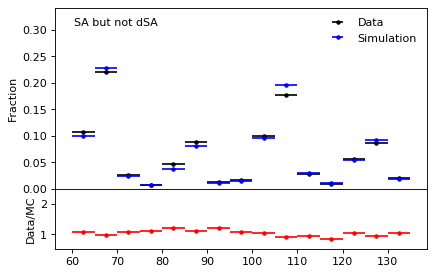

In [30]:
plot_passSA_faildSA(realized_abseta_pt, plotVar='mass')

Try for different eta slices.

In [ ]:
for absetaBin in range(1,5):
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_passSA_faildSA(realized_abseta_pt, absetaBin=absetaBin, plotVar='pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

Not much insight gained from these plots actually.

We can also try to plot the true efficiency using the generated muons in MC (in progress).

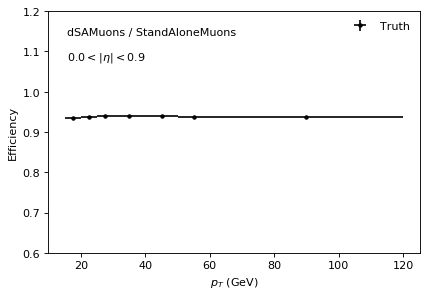

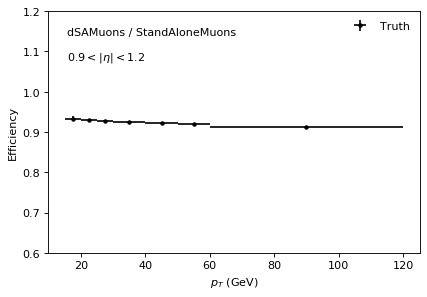

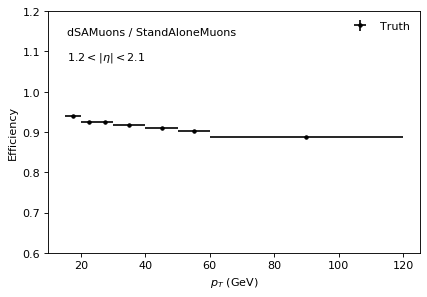

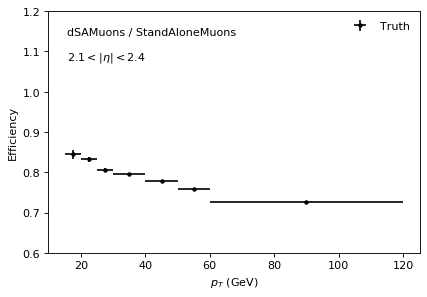

In [65]:
# df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras if subEra == 'DY_madgraph'}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {'truth': df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras if subEra == 'DY_madgraph'}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_truth_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

## dR matching study

In [25]:
particle = 'muon'
probe = 'dSAMuons'
resonance = 'Z'
eras = ['Run2018_dR0p1', 'Run2018_dR0p2', 'Run2018_dR0p3', 'Run2018_dR0p4']
subEras = ['Run2018A', 'DY_madgraph']

dfs = {era: {subEra: get_df(resonance,era,subEra) for subEra in subEras} for era in eras}
dfs_pt20 = {era: {subEra: dfs[era][subEra].filter('probe_dsa_pt>20') for subEra in subEras} for era in eras} # for use with no pT binned plots
dfs_dsa = {era: {subera: dfs[era][subera].filter('probe_isdSA==1') for subera in subEras} for era in eras}

['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/DY_madgraph_2018/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco/DY_madgraph_2018/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/DY_ma

In [10]:
dfs_params = {}

num, den = 'dSAMuons', 'genTracks'

dfs_params = {era: {subEra: get_params(dfs[era][subEra], num, den, ('abseta','pt')) for subEra in subEras} for era in eras}

In [49]:
def plot_dR_eff(dfs_sets, den, plotVar, plot_type='Data', xlabel='', additional_text='', high_quality=False):
    sample = 'Run2018A' if plot_type == 'Data' else 'DY_madgraph'
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        df = dfs_val[sample]
    
        print('len bx ', len(bx))

        x = [(bx[i]+bx[i+1])/2 for i in range(1,len(bx)-1)]
        xerr = [abs(x[i-1]-bx[i]) for i in range(1,len(bx)-1)]
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]

        print('xerr shape ', len(xerr), ' yerr shape ', len(yerr))


        ax0.errorbar(x,y,xerr=xerr,yerr=yerr, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Efficiency')
    ax0.set_xlabel(xlabel)
    ax0.set_ylim(0.6, 1.2)
    ax0.text(0.01, 0.95 - 0.00, plot_type, transform=ax0.transAxes)
    ax0.text(0.01, 0.95 - 0.05, f'Den: {den}', transform=ax0.transAxes)
    ax0.text(0.01, 0.95 - 0.10, additional_text, transform=ax0.transAxes)
        
    fig.show()
    
def plot_dR_sf(dfs_sets, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        
        df = dfs_val['Run2018A']
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
        df_mc = dfs_val['DY_madgraph']
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
        
        ratio = y/y_mc
        err_ratio = ratio * ((yerr/y)**2 + (yerr_mc/y_mc)**2)**0.5
        
        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]

        ax0.errorbar(x,ratio,xerr=xerr,yerr=err_ratio, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Data/Simulation')
    ax0.set_xlabel(xlabel)
    ax0.set_ylim(0.7, 1.1)
    ax0.text(0.01, 0.95 - 0.00, f'Den: {den}', transform=ax0.transAxes)
    ax0.text(0.01, 0.95 - 0.05, additional_text, transform=ax0.transAxes)
        
    fig.show()

len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6
len bx  8
xerr shape  6  yerr shape  6


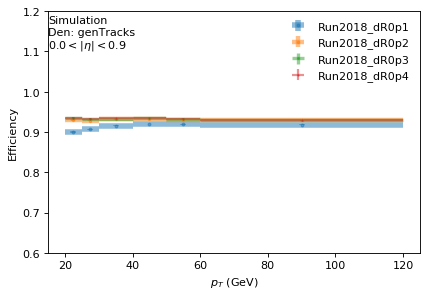

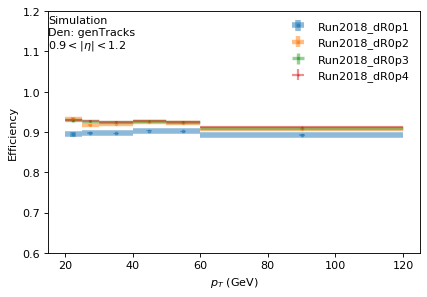

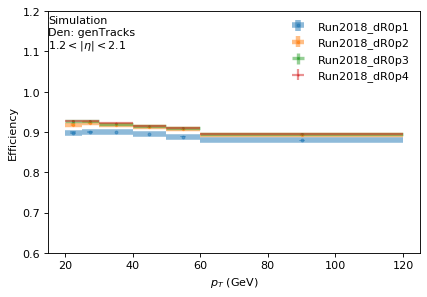

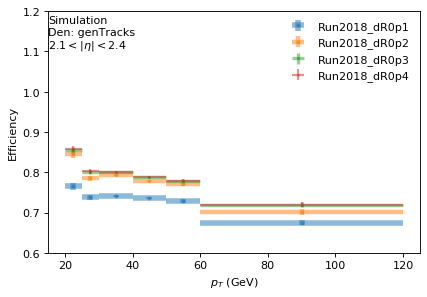

In [12]:
dfs_effs = {}
for dfs_key, dfs_val in dfs_params.items():
    dfs_effs[dfs_key] = {subEra: get_eff(dfs_val[subEra], ('abseta','pt')) for subEra in subEras}
    
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    dfs_reduced_effs = {}
    for dfs_eff_key, dfs_eff_val in dfs_effs.items():
        dfs_reduced_effs[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
        
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_dR_eff(dfs_reduced_effs, den, 'pt', plot_type='Simulation', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text, high_quality=False)

## Pileup study

In [26]:
dfs_params = {}

num, den = 'dSAMuons', 'genTracks'

dfs_params = {era: {subEra: get_params(dfs[era][subEra], num, den, ['nvtx']) for subEra in subEras} for era in eras}

Plot for data...

len bx  12
xerr shape  10  yerr shape  10
len bx  12
xerr shape  10  yerr shape  10
len bx  12
xerr shape  10  yerr shape  10
len bx  12
xerr shape  10  yerr shape  10


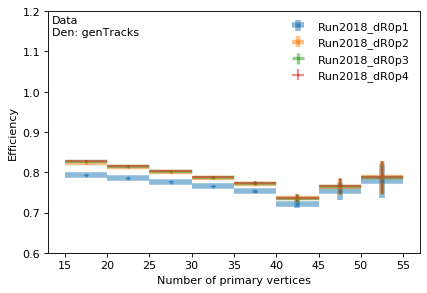

In [51]:
dfs_effs = {}
for dfs_key, dfs_val in dfs_params.items():
    dfs_effs[dfs_key] = {subEra: get_eff(dfs_val[subEra], ['nvtx']) for subEra in subEras}
    
idx = pd.IndexSlice
dfs_reduced_effs = {}
for dfs_eff_key, dfs_eff_val in dfs_effs.items():
    dfs_reduced_effs[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[num,den,:]] for subEra in subEras}
        
bz = my_config.binning()['nvtx']
plot_dR_eff(dfs_reduced_effs, den, 'nvtx', plot_type='Data', xlabel=r'Number of primary vertices', high_quality=False)

... and then for MC.

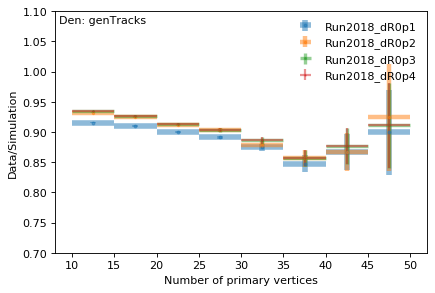

In [50]:
dfs_effs = {}
for dfs_key, dfs_val in dfs_params.items():
    dfs_effs[dfs_key] = {subEra: get_eff(dfs_val[subEra], ['nvtx']) for subEra in subEras}
    
idx = pd.IndexSlice
dfs_reduced_effs = {}
for dfs_eff_key, dfs_eff_val in dfs_effs.items():
    dfs_reduced_effs[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[num,den,:]] for subEra in subEras}
        
bz = my_config.binning()['nvtx']
plot_dR_sf(dfs_reduced_effs, den, 'nvtx', xlabel=r'Number of primary vertices', high_quality=False)